<a href="https://colab.research.google.com/github/yeonsooooooo/Langchain-Full-Course/blob/main/%5BLangGraph%5D_multi_agent_collaboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 다중 에이전트 협업

단일 에이전트는 일반적으로 단일 도메인 내에서 소수의 도구를 사용하여 효과적으로 작동할 수 있지만, `gpt-4`와 같은 강력한 모델을 사용하더라도 많은 도구를 사용하는 데에는 덜 효과적일 수 있습니다.

복잡한 작업에 접근하는 한 가지 방법은 '나누고 정복하기(divide-and-conquer)' 접근법입니다: 각 작업이나 도메인에 대해 전문화된 에이전트를 만들고 작업을 올바른 '전문가'에게 라우팅합니다.

이 노트북은 Wu 등이 작성한 논문 [AutoGen: 다중 에이전트 대화를 통한 차세대 LLM 애플리케이션 가능하게 하기](https://arxiv.org/abs/2308.08155)에서 영감을 받아 LangGraph를 사용하여 이를 수행하는 한 가지 방법을 보여줍니다.

결과적으로 생성된 그래프는 다음 다이어그램과 같은 모습일 것입니다:

![다중 에이전트 다이어그램](https://raw.githubusercontent.com/langchain-ai/langgraph/9e59039232d8a9ba2c1d11fc6ef51400b5fc11d0/examples/multi_agent/img/simple_multi_agent_diagram.png)


필요한 패키지를 설치합니다.


In [ ]:
# langchain, langchain_openai, langsmith, pandas, langchain_experimental, matplotlib 패키지를 설치합니다.
# 이 코드는 패키지 설치를 위한 pip 명령어를 포함하고 있습니다.

`python-dotenv` 라이브러리를 사용하여 환경 변수에서 토큰 정보를 로드합니다. 이 라이브러리는 `.env` 파일에 저장된 환경 변수를 읽어와서 Python 프로그램에서 사용할 수 있게 해줍니다. `load_dotenv` 함수를 호출하여 `.env` 파일의 내용을 로드합니다.


In [ ]:
# 토큰 정보를 로드하기 위한 라이브러리
# 설치 명령어: pip install python-dotenv
from dotenv import load_dotenv

# 토큰 정보 로드
load_dotenv()

True

이 함수 `_set_if_undefined`는 환경 변수가 설정되어 있지 않을 경우 사용자로부터 해당 환경 변수의 값을 입력받아 설정하는 역할을 합니다. 이 함수는 `OPENAI_API_KEY`, `LANGCHAIN_API_KEY`, `TAVILY_API_KEY` 세 개의 API 키에 대해 환경 변수가 설정되어 있는지 확인하고, 없을 경우 사용자에게 입력을 요청합니다. 또한, LangSmith 추적 기능을 활성화하고 프로젝트 이름을 'Multi-agent Collaboration'으로 설정합니다.


In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    # 주어진 환경 변수가 설정되어 있지 않다면 사용자에게 입력을 요청하여 설정합니다.
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


# OPENAI_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("OPENAI_API_KEY")
# LANGCHAIN_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("LANGCHAIN_API_KEY")
# TAVILY_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("TAVILY_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

## 에이전트 생성

다음의 헬퍼 함수들은 에이전트를 생성하는 데 도움을 줄 것입니다. 이 에이전트들은 그래프에서 노드가 될 것입니다.

그래프가 어떻게 생겼는지 바로 보고 싶다면 앞부분을 건너뛰어도 됩니다.


함수 `create_agent`는 AI 에이전트를 생성하는 데 사용됩니다. 이 에이전트는 다른 AI 보조자들과 협력하여 제공된 도구들을 사용해 질문에 대한 답변을 진행합니다. 에이전트는 최종 답변을 할 수 있는 경우 응답 앞에 'FINAL ANSWER'라고 표시하여 팀이 작업을 멈출 수 있도록 합니다. `create_agent` 함수는 `llm`, `tools`, `system_message` 세 개의 매개변수를 받으며, 각 도구의 이름을 포함한 프롬프트를 생성하여 에이전트에게 전달합니다. `format_tool_to_openai_function` 함수는 도구를 OpenAI 함수 형식으로 변환하는 데 사용되며, `ChatPromptTemplate.from_messages`는 에이전트에게 전달될 메시지 템플릿을 생성합니다. 마지막으로, 생성된 프롬프트는 `llm.bind_functions`을 통해 에이전트의 기능과 결합됩니다.


In [ ]:
import json

from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
)

from langchain.tools.render import format_tool_to_openai_function
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation


def create_agent(llm, tools, system_message: str):
    # 에이전트를 생성합니다.
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join(
        [tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)

## Tool(도구) 정의

우리의 에이전트들이 미래에 사용할 몇 가지 도구들을 정의할 것입니다


함수 `python_repl`은 주어진 파이썬 코드를 실행하고 그 결과를 반환합니다. 이 함수는 `tool` 데코레이터로 장식되어 있으며, 사용자가 제공한 코드를 `PythonREPL` 인스턴스를 통해 실행합니다. 실행 결과는 표준 출력으로 반환되며, 실행 중 발생한 예외는 오류 메시지와 함께 반환됩니다. 사용자는 `print(...)` 함수를 사용하여 값을 출력할 수 있습니다. 이 함수는 차트 생성과 같은 작업에 사용될 수 있습니다.


In [ ]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"

## 그래프 생성

이제 우리는 도구를 정의하고 몇 가지 헬퍼 함수를 만들었으므로, 아래에서 개별 에이전트를 생성하고 LangGraph를 사용하여 서로 통신하는 방법을 알려줄 것입니다.


### 상태 정의

우리는 먼저 그래프의 상태를 정의합니다. 이것은 가장 최근의 발신자를 추적하는 키와 함께 메시지의 리스트일 것입니다.


이 코드는 `langchain` 라이브러리를 사용하여 AI 에이전트와 상호작용하는 그래프 기반의 시스템을 구축하기 위한 준비 작업을 포함하고 있습니다. `AgentState` 클래스는 에이전트의 상태를 나타내며, `messages`는 `BaseMessage` 객체의 시퀀스로 구성되며, `sender`는 메시지를 보낸 사람의 식별자를 나타냅니다. `Annotated`와 `operator.add`를 사용하여 `messages` 필드에 메시지를 추가할 수 있는 기능을 제공합니다.


In [ ]:
import operator
from typing import Annotated, Sequence, Tuple, TypedDict, Union
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# 각 에이전트와 도구에 대한 다른 노드를 생성할 것입니다. 이 클래스는 그래프의 각 노드 사이에서 전달되는 객체를 정의합니다.
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### 에이전트 노드 정의하기

이제 노드를 정의할 필요가 있습니다. 먼저, 에이전트들을 위한 노드를 정의합시다.


함수 `agent_node`는 주어진 에이전트의 상태를 처리하고, 결과 메시지와 발신자 정보를 포함하는 딕셔너리를 반환합니다. `FunctionMessage` 인스턴스인 경우에는 특별한 처리를 하지 않고, 그렇지 않은 경우에는 `HumanMessage` 인스턴스로 변환합니다. `ChatOpenAI` 클래스의 인스턴스 `llm`은 모델 `gpt-4-1106-preview`를 사용하여 생성됩니다. `research_agent`와 `chart_agent`는 각각 연구자와 차트 생성기를 위한 에이전트를 생성하며, 이들은 `llm`을 사용하고 특정 도구(`tavily_tool`, `python_repl`)와 시스템 메시지를 설정합니다. `research_node`와 `chart_node`는 `functools.partial`을 사용하여 `agent_node` 함수에 필요한 인자를 미리 설정한 콜백 함수를 생성합니다.


In [ ]:
import functools


def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4-1106-preview")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Chart Generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")

### Tool Node (도구 노드) 정의

우리는 이제 도구를 실행하는 노드를 정의합니다


함수 `tool_node`는 상태 객체를 받아 마지막 메시지에서 도구 호출을 추출하고, 해당 도구를 실행한 후 결과를 `FunctionMessage` 형태로 반환합니다. 이 함수는 `ToolExecutor` 인스턴스를 사용하여 도구를 실행하며, 실행 결과는 새로운 메시지 리스트에 추가되어 반환됩니다. 단일 인자 입력은 값으로 직접 전달되며, 복수 인자의 경우 `ToolInvocation` 객체를 통해 전달됩니다.


In [ ]:
tools = [tavily_tool, python_repl]
tool_executor = ToolExecutor(tools)


def tool_node(state):
    # 그래프에서 도구를 실행하는 함수입니다.
    # 에이전트 액션을 입력받아 해당 도구를 호출하고 결과를 반환합니다.
    messages = state["messages"]
    # 계속 조건에 따라 마지막 메시지가 함수 호출을 포함하고 있음을 알 수 있습니다.
    last_message = messages[-1]
    # ToolInvocation을 함수 호출로부터 구성합니다.
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )
    # 단일 인자 입력은 값으로 직접 전달할 수 있습니다.
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # 도구 실행자를 호출하고 응답을 받습니다.
    response = tool_executor.invoke(action)
    # 응답을 사용하여 FunctionMessage를 생성합니다.
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # 기존 리스트에 추가될 리스트를 반환합니다.
    return {"messages": [function_message]}

### 에지 로직 정의

에이전트의 결과에 따라 무엇을 할지 결정하는 데 필요한 일부 에지 로직을 정의할 수 있습니다.


함수 `router`는 상태 정보를 받아서 다음 단계를 결정합니다. 상태 정보에서 마지막 메시지를 확인하고, 이 메시지에 특정 키워드가 포함되어 있는지에 따라 다음 단계를 반환합니다. 만약 마지막 메시지의 `additional_kwargs`에 `function_call`이 포함되어 있다면, 이전 에이전트가 도구를 호출한 것으로 간주하고 `"call_tool"`을 반환합니다. 만약 마지막 메시지의 내용에 `"FINAL ANSWER"`가 포함되어 있다면, 작업이 완료되었다고 판단하고 `"end"`를 반환합니다. 그렇지 않으면 작업을 계속 진행해야 하므로 `"continue"`를 반환합니다.


In [ ]:
def router(state):
    # 상태 정보를 기반으로 다음 단계를 결정하는 라우터 함수
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        # 이전 에이전트가 도구를 호출함
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # 어느 에이전트든 작업이 끝났다고 결정함
        return "end"
    return "continue"

### 그래프 정의하기

이제 모든 것을 종합하여 그래프를 정의할 수 있습니다!


이 코드는 `StateGraph` 클래스를 사용하여 상태 기반 워크플로우를 구성합니다. `AgentState`를 기반으로 `StateGraph` 객체를 생성하고, `add_node` 메서드를 사용하여 여러 노드(`Researcher`, `Chart Generator`, `call_tool`)를 추가합니다. `add_conditional_edges` 메서드를 통해 조건부 엣지를 추가하여, 각 노드가 특정 조건에 따라 다른 노드로 이동할 수 있도록 합니다. 예를 들어, `Researcher` 노드는 `router` 함수의 결과에 따라 `Chart Generator` 또는 `call_tool`로 이동하거나 워크플로우를 종료할 수 있습니다. `call_tool` 노드는 `sender` 필드를 기반으로 원래 호출한 노드로 돌아갑니다. 마지막으로 `set_entry_point` 메서드로 시작점을 `Researcher`로 설정하고, `compile` 메서드로 워크플로우 그래프를 컴파일합니다.


In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Chart Generator": "Chart Generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

## 호출

그래프가 생성되었으니 이제 호출할 수 있습니다! 몇 가지 통계를 차트로 나타내도록 해봅시다.


이 코드는 `graph` 객체의 `stream` 메소드를 사용하여 데이터를 스트리밍합니다. `HumanMessage` 객체를 사용하여 대한민국의 2018년부터 2022년까지의 출산율 데이터를 요청하고, 해당 데이터에 대한 그래프를 그리도록 요청합니다. 또한, 코드 실행이 완료되면 종료하도록 메시지에 포함되어 있습니다.

스트림은 최대 200번의 재귀 호출로 제한됩니다.


{'Researcher': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"South Korea Total Fertility Rate 2018-2022"}', 'name': 'tavily_search_results_json'}}, name='Researcher')], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [FunctionMessage(content='tavily_search_results_json response: [{\'url\': \'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9623034/\', \'content\': \'from 2.79 in 1970 to 1.74 in 1995, with a further decrease to 1.63 in 2018. In 2018, Korea (0.98) had the lowest TFR  The comprehensive graph of the changes in the trends of total live births, CBR, and TFR in Korea for the past 100 years  and trends in the population count, number of births, and birth rate in Korea, in the past and future.  rate (CBR, 5.3) and total fertility rate (TFR, 0.84), as compared with those in the previous year. Meanwhile, KoreaIn 2020, the number of births fell below 300,000 for the first time in South Korea. This year, a decline was obser

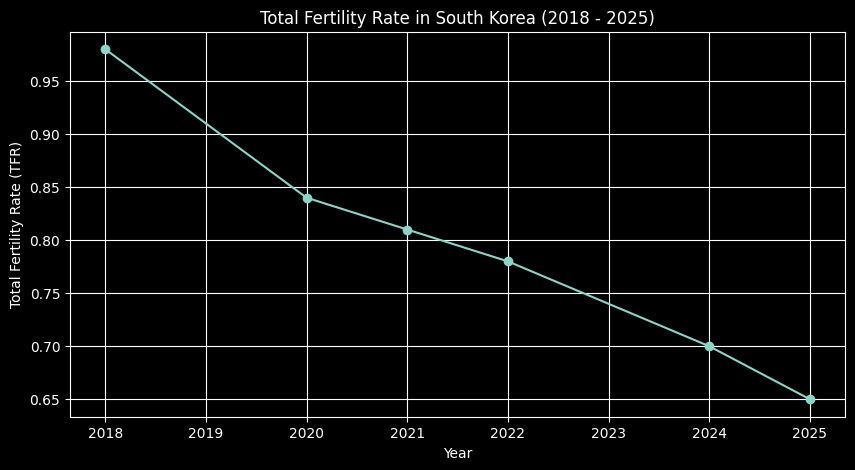

{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data\\nyears = [2018, 2020, 2021, 2022, 2024, 2025]\\nfertility_rates = [0.98, 0.84, 0.81, 0.78, 0.7, 0.65]\\n\\n# Create the plot\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, fertility_rates, marker=\'o\')\\n\\n# Add titles and labels\\nplt.title(\'Total Fertility Rate in South Korea (2018 - 2025)\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'Total Fertility Rate (TFR)\')\\n\\n# Add grid\\nplt.grid(True)\\n\\n# Show the plot\\nplt.show()"}', 'name': 'python_repl'}}, name='Chart Generator')], 'sender': 'Chart Generator'}}
----
{'call_tool': {'messages': [FunctionMessage(content="python_repl response: Succesfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Data\nyears = [2018, 2020, 2021, 2022, 2024, 2025]\nfertility_rates = [0.98, 0.84, 0.81, 0.78, 0.7, 0.65]\n\n# Create the plot\nplt.figure(figsize=(10, 5))\nplt.plot

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="대한민국의 2018년 ~ 2022년의 합계출산율에 대한 데이터를 찾아줘, "
                "그리고 2023, 2024, 2025년에 대한 전망도 찾아줘, "
                "마지막으로 수집한 데이터에 대한 그래프를 그려줘. "
                "코드 작성을 완료했다면 종료해줘."
            )
        ],
    },
    # 그래프에서 수행할 최대 단계 수
    {"recursion_limit": 200},
):
    print(s)
    print("----")